# Logistic regression model
Goal is to make a model that can predict when spot 02 will be available

1st model, assume each time point is independent



## imports

In [1]:

import os
os.chdir('..')
os.getcwd()

'/home/denny/Documents/mids/ev_charging'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data_preprocessing import datetime_processing, userinput_processing, holiday_processing

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score


## Data and Cleaning

In [3]:
# load data

In [4]:
df_of = pd.read_parquet('data/ACN-API/office001/').reset_index(drop=True)
df_of = datetime_processing(df_of)
df_of = userinput_processing(df_of)
df_of = holiday_processing(df_of)


In [5]:
df_of.head()

,_id,userID,sessionID,stationID,spaceID,siteID,clusterID,connectionTime,disconnectTime,kWhDelivered,...,doneChargingTimeDay,userID,milesRequested,WhPerMile,minutesAvailable,modifiedAt,paymentRequired,requestedDeparture,kWhRequested,is_holiday
0,5cd1d47af9af8b68f0e96713,None,19_102_260_1633_2019-03-25 16:24:42.408146,19-102-260-1633,02,19,102,2019-03-25 16:24:42+00:00,2019-03-26 01:32:12+00:00,6.146,...,25.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
1,5cd1d47af9af8b68f0e96714,None,19_102_260_1634_2019-03-25 17:19:26.896309,19-102-260-1634,03,19,102,2019-03-25 17:19:27+00:00,2019-03-26 00:38:50+00:00,3.658,...,25.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
2,5cd1d47af9af8b68f0e96715,None,19_102_260_1640_2019-03-25 21:27:32.338192,19-102-260-1640,08,19,102,2019-03-25 21:27:32+00:00,2019-03-26 03:32:03+00:00,28.330,...,26.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
3,5cd1d47df9af8b68f0e96716,None,19_102_260_1640_2019-03-26 18:33:56.204855,19-102-260-1640,08,19,102,2019-03-26 18:33:56+00:00,2019-03-27 00:45:33+00:00,12.978,...,26.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
4,5cd1d47ef9af8b68f0e96717,None,19_102_260_1640_2019-03-27 18:28:00.642220,19-102-260-1640,08,19,102,2019-03-27 18:28:01+00:00,2019-03-28 00:37:47+00:00,10.688,...,27.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False


In [6]:
df_of.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1681 entries, 0 to 1680
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   _id                   1681 non-null   object             
 1   userID                583 non-null    object             
 2   sessionID             1681 non-null   object             
 3   stationID             1681 non-null   object             
 4   spaceID               1681 non-null   object             
 5   siteID                1681 non-null   int64              
 6   clusterID             1681 non-null   int64              
 7   connectionTime        1681 non-null   datetime64[ns, UTC]
 8   disconnectTime        1681 non-null   datetime64[ns, UTC]
 9   kWhDelivered          1681 non-null   float64            
 10  doneChargingTime      1627 non-null   datetime64[ns, UTC]
 11  connectionTimeHour    1681 non-null   int32              
 12  connec

## plotting and eval

In [7]:
def make_classification_plot(cm):
    disp = ConfusionMatrixDisplay(cm)
    disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
    plt.grid(False)
    plt.show()

In [8]:
def get_results(y_test, prediction):
    cm = confusion_matrix(y_test,prediction)
    make_classification_plot(cm)
    
    results = {'tpr': cm[1, 1]/np.sum(cm[1]),
               'fpr': cm[0,1]/np.sum(cm[0]),
               'accuracy': accuracy_score(y_test, prediction),
               'precision': precision_score(y_test, prediction),
               'recall': recall_score(y_test, prediction),
        'f1':f1_score(y_test,prediction)}
    return results
    

In [9]:
results = {}

# Make X and y values

In [10]:
tmp = df_of.copy().set_index('connectionTime')
tmp = tmp[tmp['spaceID'] == '02'].sort_index()

In [11]:
y = pd.DataFrame(index=pd.date_range('2019-03-25','2021-09-12', inclusive='both', freq='h', tz=0),columns=['is_available','sessionID'])
y['is_available'] = 1
for i in range(len(tmp)):
    start_ = tmp.index[i]
    end_ = tmp.loc[start_,'disconnectTime'] 
    session_ = tmp.loc[start_,'sessionID']
    print(start_,'\t', end_,'\t', session_)
    y.loc[start_:end_,['is_available','sessionID']] = 0, session_

2019-03-25 16:24:42+00:00 	 2019-03-26 01:32:12+00:00 	 19_102_260_1633_2019-03-25 16:24:42.408146
2019-04-01 16:27:58+00:00 	 2019-04-01 19:44:01+00:00 	 19_102_260_1633_2019-04-01 16:27:57.666139
2019-04-04 16:21:35+00:00 	 2019-04-05 01:17:11+00:00 	 19_102_260_1633_2019-04-04 16:21:34.812389
2019-04-05 16:20:51+00:00 	 2019-04-06 00:42:03+00:00 	 19_102_260_1633_2019-04-05 16:20:51.232863
2019-04-08 16:26:22+00:00 	 2019-04-09 01:42:43+00:00 	 19_102_260_1633_2019-04-08 16:26:21.693268
2019-04-09 16:37:00+00:00 	 2019-04-10 01:30:22+00:00 	 19_102_260_1633_2019-04-09 16:36:59.966060
2019-04-10 16:30:22+00:00 	 2019-04-10 20:41:47+00:00 	 19_102_260_1633_2019-04-10 16:30:21.814172
2019-04-10 22:27:23+00:00 	 2019-04-11 00:58:19+00:00 	 19_102_260_1633_2019-04-10 22:27:23.356550
2019-04-11 16:25:42+00:00 	 2019-04-12 00:58:35+00:00 	 19_102_260_1633_2019-04-11 16:25:41.748842
2019-04-12 16:18:16+00:00 	 2019-04-12 23:50:04+00:00 	 19_102_260_1633_2019-04-12 16:18:16.309910
2019-04-15

In [12]:
y = y['is_available']

In [13]:
X = pd.DataFrame(index=pd.date_range('2019-03-25','2021-09-12', inclusive='both', freq='h', tz=0),columns=['dow','hour','month'])
# X['dow'] = X.index.dt.hour
X['dow'] = X.index.dayofweek
X['hour'] = X.index.hour
X['month'] = X.index.month
X['connectionTime'] = X.index
X = holiday_processing(X).drop(columns=['connectionTime'])
X

,dow,hour,month,is_holiday
2019-03-25 00:00:00+00:00,0,0,3,False
2019-03-25 01:00:00+00:00,0,1,3,False
2019-03-25 02:00:00+00:00,0,2,3,False
2019-03-25 03:00:00+00:00,0,3,3,False
2019-03-25 04:00:00+00:00,0,4,3,False
...,...,...,...,...
2021-09-11 20:00:00+00:00,5,20,9,False
2021-09-11 21:00:00+00:00,5,21,9,False
2021-09-11 22:00:00+00:00,5,22,9,False
2021-09-11 23:00:00+00:00,5,23,9,False


In [14]:
# print(f'charger spot #2 is available {np.round(y.is_available.mean()*100,3)}% of the time')
print(f'charger spot #2 is available {np.round(y.mean()*100,3)}% of the time')

charger spot #2 is available 89.297% of the time


In [15]:
X.shape[0] == y.shape[0]

True

# model time

In [16]:
! pip install scikit-learn

In [17]:
# try stratified kfold split
# if y is multiarray with time series as index
# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=3)
# for train, test in skf.split(X, y['is_available']):
#     # print(train)
#     print('train -  {}   |   test -  {}'.format(
#         np.bincount(y.iloc[train,0]), 
#         np.bincount(y.iloc[test,0])
#     ))

In [18]:
# Create hold out test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify=y)

The average accuracy is 0.893 ± 0.000
test accuracy is 0.8898383371824481


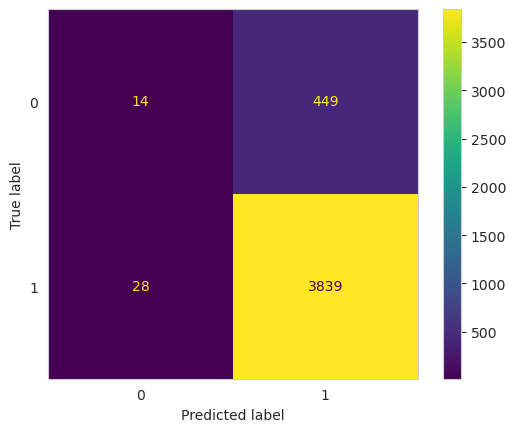

In [19]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


model = LogisticRegression()
pipe = Pipeline([
    ('ohe', OneHotEncoder()),
    ('lr', model),
])

skf = StratifiedKFold(n_splits=3)
cv_results = cross_validate(pipe, X_train, y_train, cv=skf)
test_score = cv_results["test_score"]
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(f'test accuracy is {pipe.score(X_test, y_test)}')

results['sk_log_reg_vanila_skf'] = get_results(y_test, pred)


In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X_train, y_train, cv=skf)

array([0.89191062, 0.89277672, 0.89294994])

In [21]:
# pipe.get_feature_names_out()
# pipe.get_feature_names_out()
pipe[:-1].get_feature_names_out()

array(['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'is_holiday_False'], dtype=object)

In [22]:
?LogisticRegression

The average accuracy is 0.892 ± 0.001
test accuracy is 0.8893764434180138


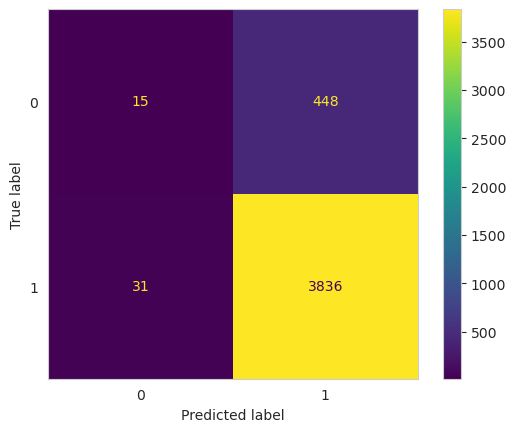

In [23]:
model = LogisticRegression(penalty='l1', solver='liblinear')
pipe = Pipeline([
    ('ohe', OneHotEncoder()),
    ('lrl1', model),
])

skf = StratifiedKFold(n_splits=3)
cv_results = cross_validate(pipe, X_train, y_train, cv=skf)
test_score = cv_results["test_score"]
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(f'test accuracy is {pipe.score(X_test, y_test)}')

results['sk_log_reg_l1_skf'] = get_results(y_test, pred)


In [24]:
print(pipe[-1].coef_.shape)
pipe[-1].n_features_in_
pipe[-1].intercept_
pipe[-1].classes_
pd.DataFrame(pipe[-1].coef_, columns=pipe[:-1].get_feature_names_out()).T
?pipe[-1]
# pipe[:-1].get_feature_names_out()

(1, 44)


In [25]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
# A sample toy binary classification dataset
# X, y = datasets.make_classification(n_classes=2, random_state=0)
# svm = LinearSVC(dual="auto", random_state=0)
lr = LogisticRegression(penalty="l2")
def confusion_matrix_scorer(clf, X, y):
     y_pred = clf.predict(X)
     cm = confusion_matrix(y, y_pred)
     return {'tn': cm[0, 0], 'fp': cm[0, 1],
             'fn': cm[1, 0], 'tp': cm[1, 1]}
cv_results = cross_validate(lr, X_train, y_train, cv=5,
                            scoring=confusion_matrix_scorer)
# Getting the test set true positive scores
print(cv_results['test_tp'])
# Getting the test set false negative scores
print(cv_results['test_fn'])

[3093 3093 3093 3093 3093]
[0 0 0 0 0]


The average accuracy is 0.870 ± 0.005
test accuracy is 0.8720554272517321


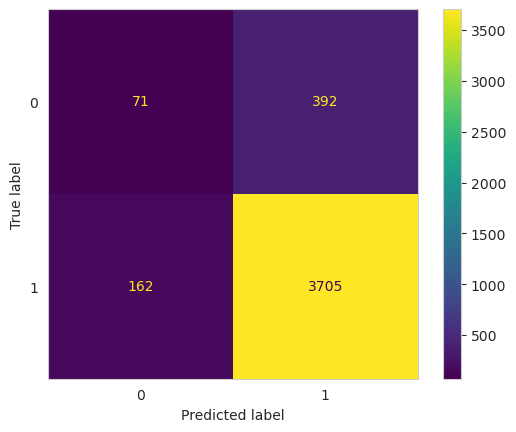

In [26]:
# tree models
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
pipe = Pipeline([
    ('ohe', OneHotEncoder()),
    ('rf', model),
])

skf = StratifiedKFold(n_splits=3)
cv_results = cross_validate(pipe, X_train, y_train, cv=skf)
test_score = cv_results["test_score"]
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(f'test accuracy is {pipe.score(X_test, y_test)}')

results['sk_rf_classification_skf'] = get_results(y_test, pred)


# stats model version

In [27]:
! pip install statsmodels

In [28]:
import statsmodels.api as sm 
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['dow']])
ohe.transform(X[['dow']])
pd.DataFrame(ohe.transform(X[['dow']]), columns=ohe.get_feature_names_out(), index=X.index)

,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
2019-03-25 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-25 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-25 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-25 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-25 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2021-09-11 20:00:00+00:00,0.0,0.0,0.0,0.0,1.0,0.0
2021-09-11 21:00:00+00:00,0.0,0.0,0.0,0.0,1.0,0.0
2021-09-11 22:00:00+00:00,0.0,0.0,0.0,0.0,1.0,0.0
2021-09-11 23:00:00+00:00,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['dow']])
ohe.transform(X[['dow']])
ohe.get_feature_names_out()
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X[['dow']]), columns=ohe.get_feature_names_out(), index=X.index), 
    y, 
    test_size=.2, 
    stratify=y)
log_reg = sm.Logit(y_train, X_train).fit() 

         Current function value: 0.359259
         Iterations: 35


/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [30]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(X[['dow']])
ohe.transform(X[['dow']])
ohe.get_feature_names_out()
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X[['dow']]), columns=ohe.get_feature_names_out(), index=X.index).drop(columns=ohe.get_feature_names_out()[0:3]), 
    y, 
    test_size=.2, 
    stratify=y)
log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())

         Current function value: 0.439012
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17319
Model:                          Logit   Df Residuals:                    17315
Method:                           MLE   Df Model:                            3
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                 -0.2901
Time:                        01:07:22   Log-Likelihood:                -7603.3
converged:                      False   LL-Null:                       -5893.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dow_3          1.6967      0.056     30.564      0.000       1.588       1.805
dow_4          1.6756      0.055     30.447      0.000       1.56

/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
print(log_reg.summary()) 

                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17319
Model:                          Logit   Df Residuals:                    17315
Method:                           MLE   Df Model:                            3
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                 -0.2901
Time:                        01:07:22   Log-Likelihood:                -7603.3
converged:                      False   LL-Null:                       -5893.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dow_3          1.6967      0.056     30.564      0.000       1.588       1.805
dow_4          1.6756      0.055     30.447      0.000       1.568       1.783
dow_5          3.4978      0.119     29.443      0.0

In [32]:
y_hat = log_reg.predict(X_test)
prediction = list(map(round, y_hat))
# confusion matrix 
cm = confusion_matrix(y_test, prediction)  
print ("Confusion Matrix : \n", cm)  
  
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[ 260  203]
 [1639 2228]]
Test accuracy =  0.5745958429561201


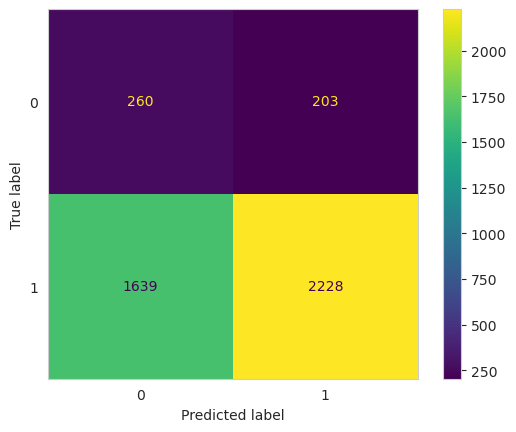

In [33]:
results['sm_log_reg_dow_skf'] = get_results(y_test, prediction)

In [34]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['hour']])
ohe.transform(X[['hour']])
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X[['hour']]), columns=ohe.get_feature_names_out(), index=X.index), 
    y, 
    test_size=.2, 
    stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(ohe.transform(X[['hour']]), columns=ohe.get_feature_names_out(), index=X.index), y['is_available'])
log_reg = sm.Logit(y_train, X_train).fit() 

Optimization terminated successfully.
         Current function value: 0.270472
         Iterations 10


In [35]:
print(log_reg.summary()) 

                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17319
Model:                          Logit   Df Residuals:                    17296
Method:                           MLE   Df Model:                           22
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                  0.2052
Time:                        01:07:23   Log-Likelihood:                -4684.3
converged:                       True   LL-Null:                       -5893.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hour_1         1.7341      0.103     16.767      0.000       1.531       1.937
hour_2         2.6347      0.148     17.815      0.000       2.345       2.925
hour_3         3.6664      0.239     15.360      0.0

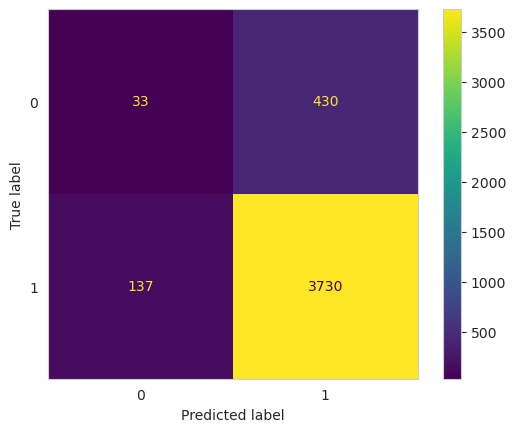

In [36]:
yhat = log_reg.predict(X_test) 
prediction = list(map(round, yhat))
results['sm_hour_sfk'] = get_results(y_test, prediction)

In [37]:
X_train

,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
2021-07-25 22:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2020-02-08 01:00:00+00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-02-11 03:00:00+00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-29 08:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-14 06:00:00+00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-18 08:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-03 03:00:00+00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-30 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2021-09-03 17:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# not weekend, the log odds is 1.782
# for the weekend, the log odds increases 2.3780, to 4.1606
y_train[X_train.hour_18==True]
# probability of ytrain
print('for not 6 PM...')
p_success = y_train[X_train.hour_18==False].mean()
p_failure = 1- p_success
odds = p_success/p_failure
log_odds = np.log(odds)
print(f'prob of success {p_success}\nprob of failure {p_failure}\nodds of success {odds}\nlog odds of success {log_odds}')
p_not6pm = p_success
print('\n\nfor 6 PM,')
p_success = y_train[X_train.hour_18==True].mean()
p_failure = 1- p_success
odds = p_success/p_failure
log_odds = np.log(odds)
print(f'prob of success {p_success}\nprob of failure {p_failure}\nodds of success {odds}\nlog odds of success {log_odds}')
print(f'\n\nthe probaility of availability changes from {p_success} to {p_not6pm}, a difference of {np.round((p_success-p_not6pm)/p_not6pm*100,3)}%')

for not 6 PM...
prob of success 0.9000782991025719
prob of failure 0.09992170089742813
odds of success 9.007836045810734
log odds of success 2.19809487027818


for 6 PM,
prob of success 0.7276536312849162
prob of failure 0.2723463687150838
odds of success 2.671794871794872
log odds of success 0.9827504831896202


the probaility of availability changes from 0.7276536312849162 to 0.9000782991025719, a difference of -19.157%


In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.19      0.07      0.10       463
           1       0.90      0.96      0.93      3867

    accuracy                           0.87      4330
   macro avg       0.55      0.52      0.52      4330
weighted avg       0.82      0.87      0.84      4330


In [40]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['month','hour']])
ohe.transform(X[['month','hour']])
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X[['month','hour']]), columns=ohe.get_feature_names_out(), index=X.index), 
    y, 
    test_size=.2, 
    stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(ohe.transform(X[['hour']]), columns=ohe.get_feature_names_out(), index=X.index), y['is_available'])
log_reg = sm.Logit(y_train, X_train).fit() 

Optimization terminated successfully.
         Current function value: 0.260829
         Iterations 11


In [41]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17319
Model:                          Logit   Df Residuals:                    17285
Method:                           MLE   Df Model:                           33
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                  0.2335
Time:                        01:07:23   Log-Likelihood:                -4517.3
converged:                       True   LL-Null:                       -5893.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month_2        0.7269      0.118      6.165      0.000       0.496       0.958
month_3        0.3513      0.103      3.399      0.001       0.149       0.554
month_4        0.8824      0.103      8.576      0.0

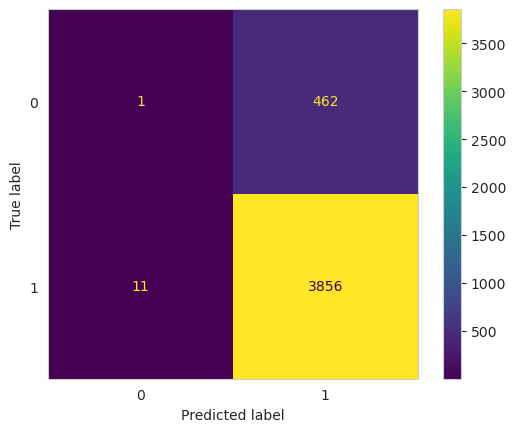

In [42]:
yhat = log_reg.predict(X_test) 
prediction = list(map(round, yhat))
results['sm_month_hour_skf'] = get_results(y_test, prediction)


In [43]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X)
ohe.transform(X)
ohe.get_feature_names_out()[0]

X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X), columns=ohe.get_feature_names_out(), index=X.index), #.drop(columns=ohe.get_feature_names_out()[0]), 
    y, 
    test_size=.2, 
    stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(ohe.transform(X[['hour']]), columns=ohe.get_feature_names_out(), index=X.index), y['is_available'])
log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())

         Current function value: 0.229056
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17319
Model:                          Logit   Df Residuals:                    17279
Method:                           MLE   Df Model:                           39
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                  0.3269
Time:                        01:07:24   Log-Likelihood:                -3967.0
converged:                      False   LL-Null:                       -5893.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dow_1         -0.0224      0.087     -0.258      0.797      -0.193       0.148
dow_2         -0.1616      0.086     -1.883      0.060      -0.33

/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


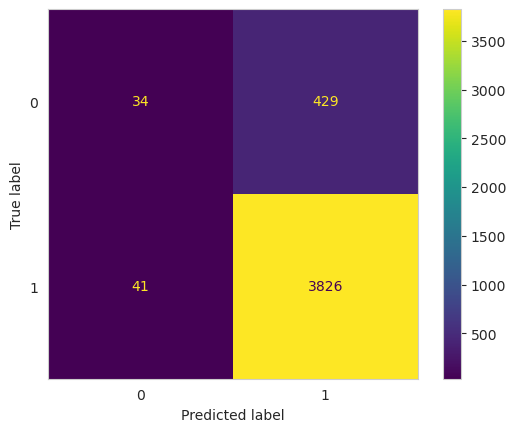

In [44]:
yhat = log_reg.predict(X_test) 
prediction = list(map(round, yhat))
results['sm_month_hour_dow_skf'] = get_results(y_test, prediction)

guess always available and never available


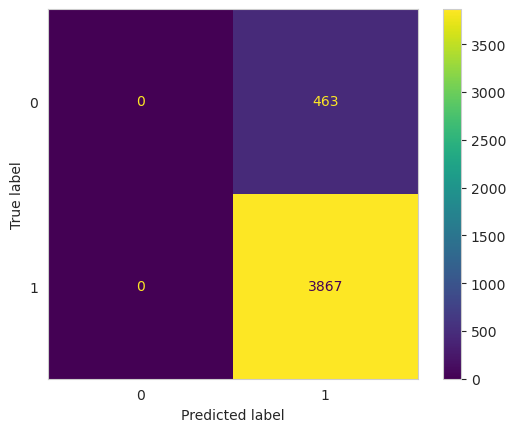

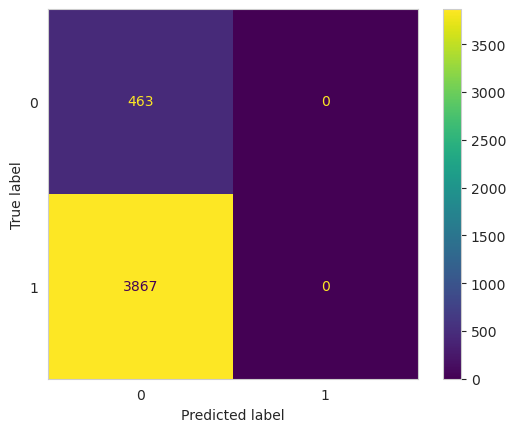

/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
print('guess always available and never available')
results['always_available'] =  get_results(y_test, [1]*len(y_test))
results['never_available'] =  get_results(y_test, [0]*len(y_test))


In [46]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['month']])
ohe.transform(X[['month']])
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X[['month']]), columns=ohe.get_feature_names_out(), index=X.index), 
    y, 
    test_size=.2, 
    stratify=y)
log_reg = sm.Logit(y_train, X_train).fit() 

Optimization terminated successfully.
         Current function value: 0.359569
         Iterations 6


In [47]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17319
Model:                          Logit   Df Residuals:                    17308
Method:                           MLE   Df Model:                           10
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                -0.05662
Time:                        01:07:25   Log-Likelihood:                -6227.4
converged:                       True   LL-Null:                       -5893.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month_2        2.0379      0.095     21.517      0.000       1.852       2.224
month_3        1.7532      0.078     22.545      0.000       1.601       1.906
month_4        2.2023      0.080     27.488      0.0

In [48]:
yhat = log_reg.predict(X_test) 
prediction = list(map(round, yhat))
yhat

2021-07-25 06:00:00+00:00    0.896163
2021-04-28 08:00:00+00:00    0.900460
2020-03-11 23:00:00+00:00    0.852359
2021-04-14 17:00:00+00:00    0.900460
2021-05-10 02:00:00+00:00    0.919391
                               ...   
2019-10-06 00:00:00+00:00    0.878276
2019-08-01 03:00:00+00:00    0.900618
2021-03-16 21:00:00+00:00    0.852359
2020-10-02 15:00:00+00:00    0.878276
2021-05-25 11:00:00+00:00    0.919391
Length: 4330, dtype: float64

In [49]:
print(classification_report(y_test, prediction))
confusion_matrix(y_test, prediction)


              precision    recall  f1-score   support

           0       0.14      0.10      0.11       463
           1       0.90      0.93      0.91      3867

    accuracy                           0.84      4330
   macro avg       0.52      0.51      0.51      4330
weighted avg       0.82      0.84      0.83      4330


array([[  44,  419],
       [ 263, 3604]])

In [50]:
from sklearn.metrics import  f1_score, precision_score, recall_score
print(f'Precision: out of all the times the model predicted the charger would be available, {np.round(precision_score(y_test, prediction)*100,3)}% of the time it actually was available')
print(f'Recall: out of all the times the charger was available, the model predicted the outcome correctly for {np.round(recall_score(y_test, prediction)*100,3)}% of those times')
print(f'F1 score: the precision recall balance of the model was {np.round(f1_score(y_test,prediction),3)}')
print(f'support available:   {np.sum(y_test==1)}')
print(f'support unavailable: {np.sum(y_test==0)}')


Precision: out of all the times the model predicted the charger would be available, 89.585% of the time it actually was available
Recall: out of all the times the charger was available, the model predicted the outcome correctly for 93.199% of those times
F1 score: the precision recall balance of the model was 0.914
support available:   3867
support unavailable: 463


In [51]:
pd.DataFrame(results).T

,tpr,fpr,accuracy,precision,recall,f1
sk_log_reg_vanila_skf,0.992759,0.969762,0.889838,0.895289,0.992759,0.941508
sk_log_reg_l1_skf,0.991983,0.967603,0.889376,0.895425,0.991983,0.941234
sk_rf_classification_skf,0.958107,0.846652,0.872055,0.904320,0.958107,0.930437
sm_log_reg_dow_skf,0.576157,0.438445,0.574596,0.916495,0.576157,0.707526
sm_hour_sfk,0.964572,0.928726,0.869053,0.896635,0.964572,0.929363
sm_month_hour_skf,0.997155,0.997840,0.890762,0.893006,0.997155,0.942211
sm_month_hour_dow_skf,0.989397,0.926566,0.891455,0.899177,0.989397,0.942132
always_available,1.000000,1.000000,0.893072,0.893072,1.000000,0.943516
never_available,0.000000,0.000000,0.106928,0.000000,0.000000,0.000000


# Interpreting model coefficients

In [52]:
# probability of ytrain
p_success = y_train.mean()
p_failure = 1- p_success
odds = p_success/p_failure
log_odds = np.log(odds)
print(f'prob of success {p_success}\nprob of failure {p_failure}\nodds of success {odds}\nlog odds of success {log_odds}')

prob of success 0.892949939372943
prob of failure 0.10705006062705702
odds of success 8.341423948220061
log odds of success 2.121233938993369


In [53]:
dummy_1 = pd.DataFrame([1]*len(y_train), columns=['intercept'], index=y_train.index)
int_model = sm.Logit(y_train, dummy_1).fit()

Optimization terminated successfully.
         Current function value: 0.340303
         Iterations 6


In [54]:
print(int_model.summary())

                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17319
Model:                          Logit   Df Residuals:                    17318
Method:                           MLE   Df Model:                            0
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:               3.623e-11
Time:                        01:07:25   Log-Likelihood:                -5893.7
converged:                       True   LL-Null:                       -5893.7
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1212      0.025     86.309      0.000       2.073       2.169


In [55]:
print(f'the model intercept term is {int_model.params.iloc[0]} which is the same as the log odds of the training set {log_odds}')

the model intercept term is 2.121233938993369 which is the same as the log odds of the training set 2.121233938993369


# new model

In [56]:
X['is_weekend'] = X['dow'].isin([5,6])
X

,dow,hour,month,is_holiday,is_weekend
2019-03-25 00:00:00+00:00,0,0,3,False,False
2019-03-25 01:00:00+00:00,0,1,3,False,False
2019-03-25 02:00:00+00:00,0,2,3,False,False
2019-03-25 03:00:00+00:00,0,3,3,False,False
2019-03-25 04:00:00+00:00,0,4,3,False,False
...,...,...,...,...,...
2021-09-11 20:00:00+00:00,5,20,9,False,True
2021-09-11 21:00:00+00:00,5,21,9,False,True
2021-09-11 22:00:00+00:00,5,22,9,False,True
2021-09-11 23:00:00+00:00,5,23,9,False,True


In [57]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['is_weekend']])
ohe.transform(X[['is_weekend']])
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(ohe.transform(X[['is_weekend']]), columns=ohe.get_feature_names_out(), index=X.index), y)
log_reg = sm.Logit(y_train, sm.add_constant(X_train)).fit() 
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.314377
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                16236
Model:                          Logit   Df Residuals:                    16234
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                 0.07295
Time:                        01:07:25   Log-Likelihood:                -5104.2
converged:                       True   LL-Null:                       -5505.9
Covariance Type:            nonrobust   LLR p-value:                1.007e-176
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.7860      0.026     67.506      0.000       1.734       1.838
is_weekend_Tru

$logit(p/1-p) = \beta_0 + \beta_1*is_weekend$

In [58]:
# not weekend, the log odds is 1.782
# for the weekend, the log odds increases 2.3780, to 4.1606
y_train[X_train.is_weekend_True==True]
# probability of ytrain
print('for weekdays...')
p_success = y_train[X_train.is_weekend_True==False].mean()
p_failure = 1- p_success
odds = p_success/p_failure
log_odds = np.log(odds)
print(f'prob of success {p_success}\nprob of failure {p_failure}\nodds of success {odds}\nlog odds of success {log_odds}')
p_notweekend=p_success
print('\n\nfor weekends,')
p_success = y_train[X_train.is_weekend_True==True].mean()
p_failure = 1- p_success
odds = p_success/p_failure
log_odds = np.log(odds)
print(f'prob of success {p_success}\nprob of failure {p_failure}\nodds of success {odds}\nlog odds of success {log_odds}')
print(f'\n\nthe probaility of availability changes from {p_success} to {p_notweekend}, a difference of {np.round((p_success-p_notweekend)/p_notweekend*100,3)}%')

for weekdays...
prob of success 0.8564420345985024
prob of failure 0.14355796540149757
odds of success 5.965827338129495
log odds of success 1.7860477446964698


for weekends,
prob of success 0.9867879575481915
prob of failure 0.013212042451808514
odds of success 74.68852459016405
log odds of success 4.313326460393763


the probaility of availability changes from 0.9867879575481915 to 0.8564420345985024, a difference of 15.219%


In [59]:
?log_reg
lowt = log_reg.params.iloc[0] + log_reg.params.iloc[1]
lowf = log_reg.params.iloc[0]
prwt = np.exp(lowt)/(1+np.exp(lowt))
prwf = np.exp(lowf)/(1+np.exp(lowf))
print(f'probability of weekend availability {prwt}\nprobability of weekday availability {prwf}')

probability of weekend availability 0.9867879575481914
probability of weekday availability 0.8564420345985024


In [60]:
# weekend add 2.4 to the log odds of availability
# p  exp(beta X)/ 1+ exp(beta X)
# the weekend makes spot availability 2.4 times more likely to occur
# the odds of is availability change by exp(2.49) time for c unit increase in x
np.exp(2.493)

12.097514278865066

In [61]:
print(f'the change in log odds of the day being a weekend is {2.493}')
print(f'that means that the change in odds is {np.exp(2.493)}')

the change in log odds of the day being a weekend is 2.493
that means that the change in odds is 12.097514278865066


In [62]:
is_weekend = 0
P_non_weekend = np.exp(1.7667 + 2.4931 * is_weekend)/(1+np.exp(1.7667 + 2.4931 * is_weekend))
is_weekend = 1
P_weekend = np.exp(1.7667 + 2.4931 * is_weekend)/(1+np.exp(1.7667 + 2.4931 * is_weekend))
print(np.round(P_non_weekend,3), np.round(P_weekend, 3))


0.854 0.986


In [63]:
np.exp(5.2057)/(1+np.exp(5.2057))

0.9945447139365461